In [1]:
# This script is referred from http://rdkit.blogspot.jp/2015/02/new-drawing-code.html
# and http://cheminformist.itmol.com/TEST/wp-content/uploads/2015/07/rdkit_moldraw2d_2.html
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

import numpy as np
from matplotlib import pyplot as plt
import qml
import ase.units

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/hitp')
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import find_converged as fc
import qml_interface as qmi
from explore_qml_data import shift2center

In [2]:
def get_mean_distance(reps,selection):
    distances = np.zeros(len(reps))
    for s in selection:
        dist_temp = []
        for r in reps:
            dist_temp.append(np.linalg.norm(r-s))
        distances += dist_temp
    distances_mean = distances/len(selection)
    return(distances_mean)

def make_selection(Z, n, select_molecules):
    for i in range(n):
        # get distance to all atomic reps
        distances = get_mean_distance(reps_el[Z], selected_reps[Z])
        # get index of atom with largest distance to s A(d_max)
        max_dist_idx = np.where(np.amax(distances) == distances)[0][0] # index with in dictionary
        index = idx_el[Z][max_dist_idx] # index within full representation array
        # get index of molecule that contains A(d_max)
        global_idx = qmi.get_global_idx([index], molecule_size) # get idx of molecule
        select_molecules.extend(global_idx) # save index for later
        local_idc = qmi.get_local_idx(global_idx, molecule_size) # get local idc of atoms in molecule
        reps_new_molecule, idc_new_molecule = sort_by_element(representations[local_idc]) # sort reps by element

        # add atoms to list of atoms selected for calculation
        for Z in reps_new_molecule.keys():
            selected_reps[Z].extend(reps_new_molecule[Z])
            selected_reps_index[Z].extend(idc_new_molecule[Z])
    return(select_molecules)

def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

def render_svg(svg):
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))


def sort_by_element(representations):
    """
    separate representations by element, store in dictionary divided by element
    """
    reps_el = {1:[], 6:[], 7:[], 8:[]}
    idx_el = {1:[], 6:[], 7:[], 8:[]}
    for i,r in enumerate(representations):
        Z = int(np.round(np.power(r[0]*2, 1/2.4)))
        reps_el[Z].append(r)
        # index in representation matrix, can be used to get index of molecule and this way its name and smiles string
        idx_el[Z].append(i)
    return(reps_el, idx_el)

In [3]:
paths = qmi.wrapper_alch_data()
alchemy_data, molecule_size = qmi.load_alchemy_data(paths)
representations = qmi.generate_atomic_representations(alchemy_data, molecule_size)

In [4]:
path_d001212 = '/home/misa/datasets/qm9/dsgdb9nsd_001212.xyz'
d001212 = qml.Compound(xyz=path_d001212)
d001212.coordinates = shift2center(d001212.coordinates, np.array([10, 10, 10]))
d001212.coordinates = d001212.coordinates/ase.units.Bohr
d001212_rep = qml.representations.generate_atomic_coulomb_matrix(d001212.nuclear_charges, d001212.coordinates, size=20, sorting='row-norm')

In [5]:
# sort representations by element for d001212_rep
selected_reps, selected_reps_index = sort_by_element(d001212_rep)
select_molecules = [89] # 89 == dsgdb9nsd_001212

selected_reps: representations sorted by element for atoms that will be calculated

selected_reps_index: indices of representations sorted by element for atoms that will be calculated

selected_molecules: index of molecules (in alchemy_data) that are selected for calculation

In [6]:
# sort representations by element
reps_el, idx_el = sort_by_element(representations)

selected_reps: representations sorted by element for all atoms
    
selected_reps_index: indices of representations sorted by element for all atoms

### Make most diverse set

In [7]:
select_molecules = [89]
select_molecules = make_selection(1, 4, select_molecules)
select_molecules = make_selection(6, 10, select_molecules)
select_molecules = make_selection(7, 3, select_molecules)
select_molecules = make_selection(8, 3, select_molecules)

In [8]:
selected_reduced = list(set(select_molecules))
selected_reduced

[2, 546, 4, 292, 547, 7, 552, 8, 523, 12, 14, 244, 89, 186, 251, 540, 541, 542]

In [9]:
# make paths to xyz
paths_xyz = []
for i in selected_reduced:
    comp = paths[i].split('/')[-2]
    a = f'/home/misa/datasets/qm9/{comp}.xyz'
    paths_xyz.append(a)


In [10]:
def get_smiles(file):
    with open(file, 'r') as f:
        content = f.readlines()
        smiles = content[-2].split()[0]
    return(smiles)

In [12]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

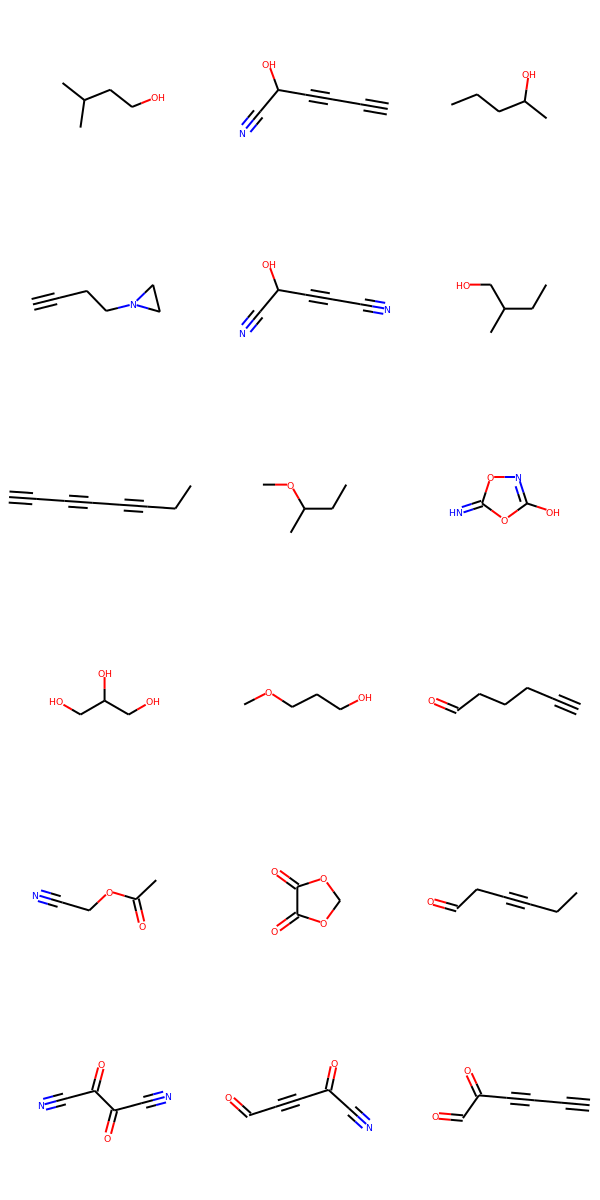

In [16]:
smiles = []
for p in paths_xyz:
    smiles.append(get_smiles(p))
ms = [Chem.MolFromSmiles(x) for x in smiles]
Draw.MolsToGridImage(ms)

In [ ]:
all_smiles_canonical = []
for s in all_smiles:
    all_smiles_canonical.append(Chem.CanonSmiles(s))

In [69]:
indices_selected_molecules = [2,546,8]

In [100]:
sm = 'N=C2CC1(CC1)O2'
i = all_smiles_canonical.index(sm)
indices_selected_molecules.append(i)
ms = [Chem.MolFromSmiles(x) for x in all_smiles]
kwargs = ['useSVG']
Draw.MolsToGridImage(ms[i:i+1], molsPerRow=6, maxMols = 600)

ValueError: 'N=C2CC1(CC1)O2' is not in list

In [99]:
indices_selected_molecules.extend()

[2, 546, 8, 523, 89, 186, 55, 153, 144, 142, 168, 174, 203, 481, 523, 248, 536]

In [114]:
indices_selected_molecules.extend([176,215,217])

In [112]:
row = 37
col = 2
print(col-1 + (row-1)*6)

217


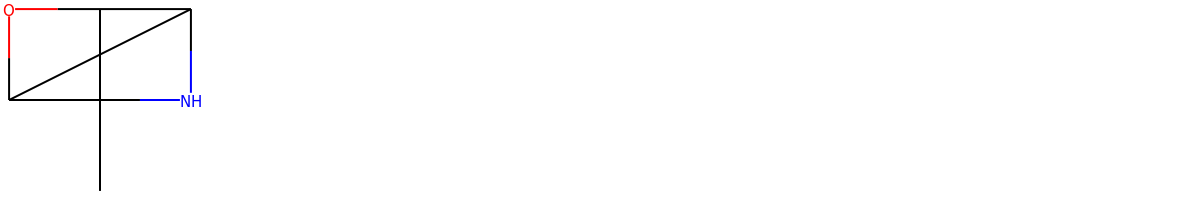

In [113]:
i = 217
Draw.MolsToGridImage(ms[i:i+1], molsPerRow=6, maxMols = 600)

In [119]:
base = '/home/misa/projects/Atomic-Energies/data/vacuum_reference/qm9_data/'
selected_molecules_paths = []
for p in indices_selected_molecules:
    selected_molecules_paths.append(base + paths[p].split('/')[-2])

In [121]:
with open('/home/misa/projects/Atomic-Energies/data/vacuum_reference/test_run.txt', 'w') as f:
    for line in selected_molecules_paths:
        f.write(line + '\n')

In [20]:
# make paths to xyz
all_paths_xyz = []
for i in paths:
    comp = i.split('/')[-2]
    a = f'/home/misa/datasets/qm9/{comp}.xyz'
    all_paths_xyz.append(a)

In [22]:
all_smiles = []
for p in all_paths_xyz:
    all_smiles.append(get_smiles(p))

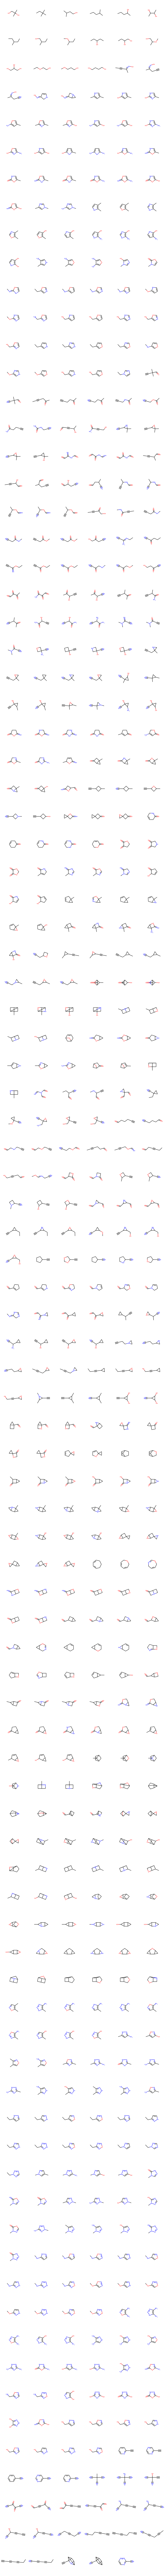

In [41]:
ms = [Chem.MolFromSmiles(x) for x in all_smiles]
kwargs = ['useSVG']
#Draw.ShowMol(ms, maxMols = 600)
Draw.MolsToGridImage(ms, molsPerRow=6, maxMols = 600)

In [32]:
type(ms[0])

rdkit.Chem.rdchem.Mol